In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
from PIL import Image

from ip_adapter import SEIImageProjModel
from torchvision import transforms


base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"

# projector_ckpt = "/mnt/hwfile/gveval/yangshuo/ckpt/adapter/IN100/2fc-bs32-lr_0.0005-initScale1/checkpoint-8000.pt"
# projector_ckpt = "/mnt/hwfile/gveval/yangshuo/ckpt/adapter/IN100/2fc-bs32-lr_0.0005-initScale1/checkpoint-14000.pt"
# projector_ckpt = "/mnt/hwfile/gveval/yangshuo/ckpt/adapter/IN100_2/2fc-bs32-lr_0.0005-initScale0/checkpoint-10000.pt"
projector_ckpt = "/mnt/hwfile/gveval/yangshuo/ckpt/adapter/IN100_2/2fc-bs32-lr_0.0005-initScale1-sentence-20240816-193125/checkpoint-14000.pt"
image_encoder_path = "openai/clip-vit-large-patch14"

device = "cuda"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(device, dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
).to(device)
image_encoder = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_image_processor = CLIPImageProcessor()
text_tokenizer = pipe.tokenizer
text_model = pipe.text_encoder

image_proj_model = SEIImageProjModel(
    cross_attention_dim=768,
    clip_embeddings_dim=image_encoder.config.projection_dim,
).to(device) 
image_proj_model.load_state_dict(torch.load(projector_ckpt))

/mnt/petrelfs/yangshuo/anaconda3/envs/SyntheticData/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.10.layer_norm2.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.7.self_attn.q_proj.weight', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.enco

<All keys matched successfully>

In [28]:
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n01498041/n01498041_6128.JPEG' # stingray
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n01498041/n01498041_3869.JPEG'
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n01498041/n01498041_28.JPEG'
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n01443537/n01443537_2.JPEG' # goldfish
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n03594945/n03594945_17497.JPEG' # jeep
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n03594945/n03594945_211.JPEG'
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n03594945/n03594945_23091.JPEG'
# img_path = '/mnt/petrelfs/share/imagenet/images/train/n01582220/n01582220_261.JPEG' # magpie
img_path = '/mnt/petrelfs/share/imagenet/images/train/n01582220/n01582220_454.JPEG'
raw_image = Image.open(img_path).convert("RGB")
clip_image = clip_image_processor(images=raw_image, return_tensors="pt").pixel_values
image_embeds = image_encoder(clip_image.to(device)).image_embeds

projected_image_embed = image_proj_model(image_embeds)

prompt = "class" # class is a placeholder
prompt = "A high quality photo of a class"
neg_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
text_inputs = text_tokenizer(prompt, return_tensors="pt", max_length=77, padding="max_length", truncation=True)["input_ids"]
tokens = text_tokenizer.convert_ids_to_tokens(text_inputs[0])
word_index = tokens.index("class</w>")
# print(f"tokens: {tokens}")
# print(f"index: {word_index}")
text_outputs = text_model(input_ids=text_inputs.to(device))
text_embeds = text_outputs.last_hidden_state
text_embeds[:, word_index, :] = projected_image_embed

neg_text_inputs = text_tokenizer(neg_prompt, return_tensors="pt", max_length=77, padding="max_length", truncation=True)["input_ids"]
neg_text_outputs = text_model(input_ids=neg_text_inputs.to(device))
neg_text_embeds = neg_text_outputs.last_hidden_state

In [4]:
print(tokens)
print(word_index)

['<|startoftext|>', 'class</w>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>'

  0%|          | 0/50 [00:00<?, ?it/s]

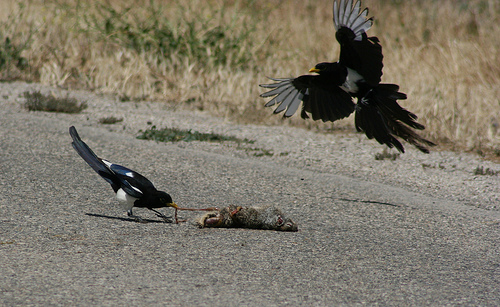

In [5]:
ori_image = Image.open(img_path)
ori_image

  0%|          | 0/50 [00:00<?, ?it/s]

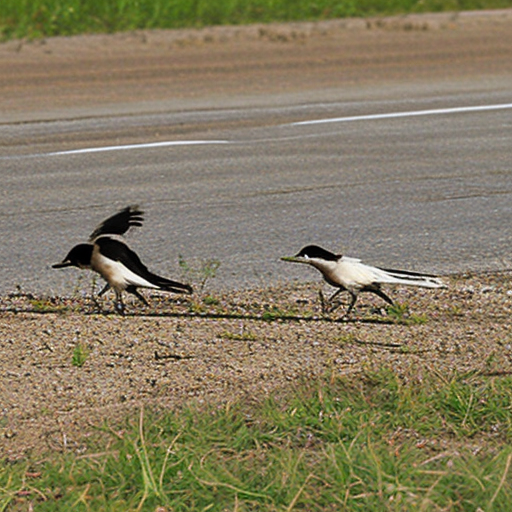

In [29]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
# Generate the image
images = pipe(prompt_embeds=text_embeds, negative_prompt_embeds=neg_text_embeds).images
grid = image_grid(images,1,1)
grid

In [33]:
# generate from embedding
import  torch
import os
import numpy as np
tensor_root = "/mnt/hwfile/gveval/yangshuo/output/SEI_tensor/IN100_2-sentence-14k"

def load_data(folder_path):
    tensors = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pt"):
            tensor = torch.load(os.path.join(folder_path, filename)).cpu()
            tensors.append(tensor.detach())
    data = torch.stack(tensors[:50])
    return data
data = load_data(tensor_root+"/n01582220") # magpie

In [34]:
print(data.shape) #torch.Size([50, 768])

torch.Size([50, 768])


  0%|          | 0/50 [00:00<?, ?it/s]

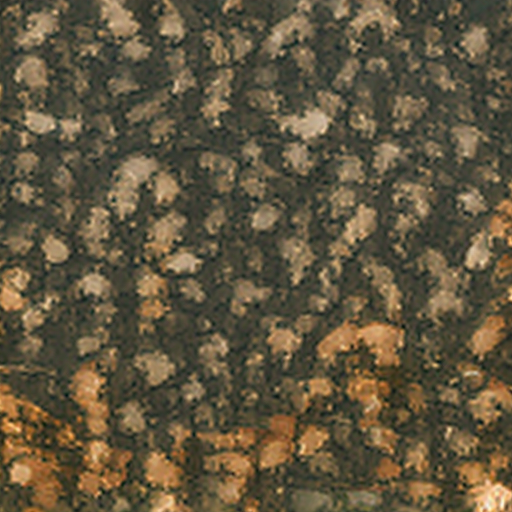

In [30]:
images = pipe(prompt_embeds=data[4:5].unsqueeze(0).repeat(1,77,1), negative_prompt_embeds=neg_text_embeds, seed=0).images
images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

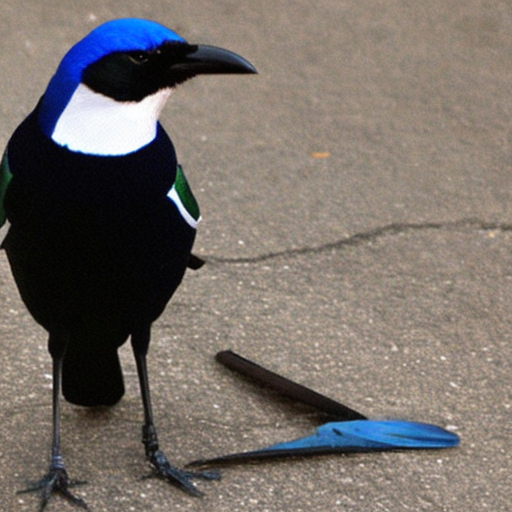

In [40]:
weight = 1
index = 11
text_embeds[:, word_index, :] = data[index:index+1] * weight
images = pipe(prompt_embeds=text_embeds).images
images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

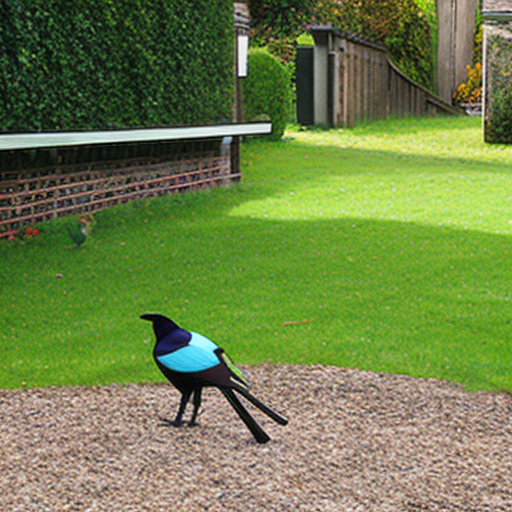

In [32]:
weight = 2
text_embeds[:, word_index, :] = data[4:5] * weight
images = pipe(prompt_embeds=text_embeds, negative_prompt_embeds=neg_text_embeds, seed=0).images
images[0]